<a href="https://colab.research.google.com/github/anaulia19/RockPaperScissors_ImageClassification/blob/main/RockPaperScissors_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rock Paper Scissors Image Classification**

## **Description**
This project implements a Convolutional Neural Network (CNN) to classify images of hand gestures representing rock, paper, and scissors, aiming to fulfill a Dicoding assignment. The model is trained on a dataset of images and can predict the gesture shown in new, unseen images, demonstrating practical application of deep learning techniques for image classification tasks.

# **Import and install the required libraries**




In [1]:
# Install split folders
!pip install split_folders

In [2]:
# Import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import splitfolders
import numpy as np
from google.colab import files
%matplotlib inline

# Check tensorflow version
print(tf.__version__)

2.17.0


This code sets up the environment for building and training deep learning models using TensorFlow and Keras. It imports essential libraries and modules for image data preprocessing, model creation, and evaluation. Additionally, it includes tools for visualizing data and handling file operations. The `%matplotlib inline` directive ensures that plots are displayed within the notebook. The code also prints the TensorFlow version to verify the installation.

# **Download Dataset**

Download the dataset from GitHub and extract it


In [3]:
# Download and extract dataset
dataset_url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
dataset_zip = 'rps_dataset.zip'
dataset_dir = 'rps_dataset'

In [4]:
def download_extract_dataset(url, zip_file, extract_dir):
    import urllib.request
    urllib.request.urlretrieve(url, zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

download_extract_dataset(dataset_url, dataset_zip, dataset_dir)

# **Split Data**

This section will split the data into two parts: training data and validation data.

In [5]:
# Split dataset
input_folder = os.path.join(dataset_dir, 'rockpaperscissors', 'rps-cv-images')
output_folder = os.path.join(dataset_dir, 'rockpaperscissors', 'data')
splitfolders.ratio(input=input_folder, output=output_folder, seed=1337, ratio=(0.6, 0.4))

# Create data directories
data_dir = os.path.join(dataset_dir, 'rockpaperscissors', 'data')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')

# Display the contents of the train and validation directories
print("\nContents of the train directory:", os.listdir(train_dir))
print("Contents of the validation directory:", os.listdir(validation_dir))

Copying files: 2188 files [00:03, 665.08 files/s]


Contents of the train directory: ['scissors', 'rock', 'paper']
Contents of the validation directory: ['scissors', 'rock', 'paper']


In [6]:
# Count and display the number of images in the directory
print(len(os.listdir(os.path.join(train_dir, 'paper'))))
print(len(os.listdir(os.path.join(train_dir, 'scissors'))))
print(len(os.listdir(os.path.join(train_dir, 'rock'))))

427
450
435


In [7]:
# Create paths to the train directory for each class
train_paper_dir = os.path.join(train_dir, 'paper')
train_scissors_dir = os.path.join(train_dir, 'scissors')
train_rock_dir = os.path.join(train_dir, 'rock')

# Create paths to the validation directory for each class
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')
validation_rock_dir = os.path.join(validation_dir, 'rock')

In [8]:
# Retrieve the list of image file names for each class in the train directory
paper_imgs = os.listdir(train_paper_dir)
scissors_imgs = os.listdir(train_scissors_dir)
rock_imgs = os.listdir(train_rock_dir)

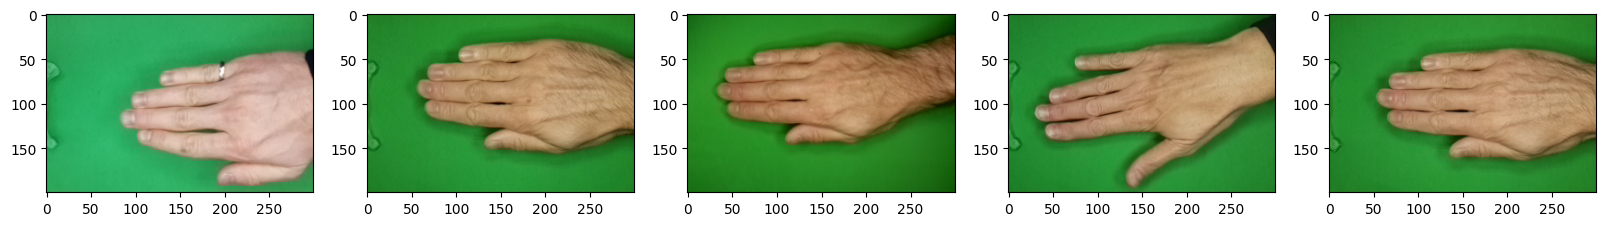

In [9]:
# Display class paper
plt.figure(figsize=(20, 5))
for i, img_path in enumerate(paper_imgs[:5]):
  sp = plt.subplot(1, 5, i+1)
  img = mpimg.imread(os.path.join(train_paper_dir, img_path))
  plt.imshow(img)
plt.show()

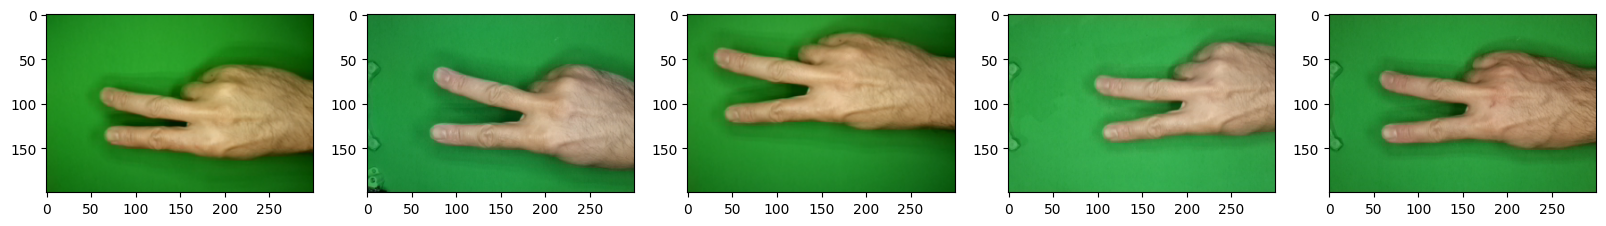

In [10]:
# Display class scissors
plt.figure(figsize=(20, 5))
for i, img_path in enumerate(scissors_imgs[:5]):
  sp = plt.subplot(1, 5, i+1)
  img = mpimg.imread(os.path.join(train_scissors_dir, img_path))
  plt.imshow(img)
plt.show()

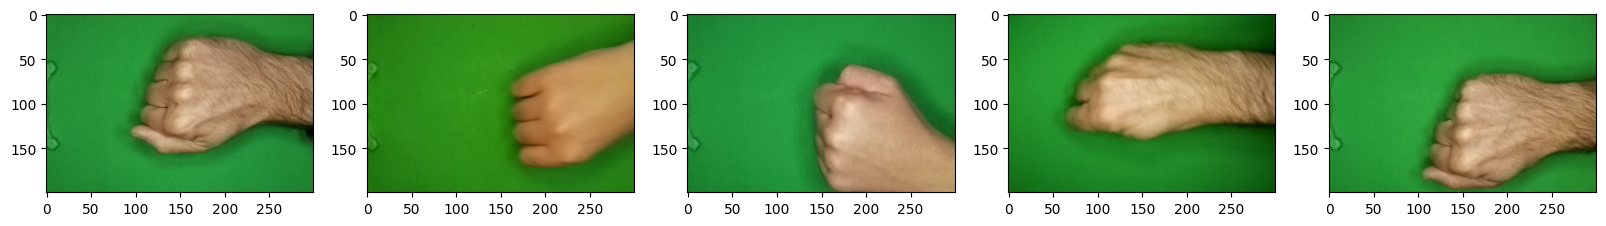

In [11]:
# Display class rock
plt.figure(figsize=(20, 5))
for i, img_path in enumerate(rock_imgs[:5]):
  sp = plt.subplot(1, 5, i+1)
  img = mpimg.imread(os.path.join(train_rock_dir, img_path))
  plt.imshow(img)
plt.show()

# **Image Augmentation**

Use ImageDataGenerator for image augmentation.

In [12]:
# Create an image data generator for training.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.9999,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Create an image data generator for validation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.9999
)

In [13]:
# Create a data generator for training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Create a data generator for validation
val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [14]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

# **Build Model**

In [15]:
# Create a Sequential model for CNN with improvements
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Reshape(target_shape=(512,)),  # Adjust according to the output dimensions of Flatten
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Display a summary of the information for the updated model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 427,683 (1.63 MB)

 Trainable params: 427,683 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

#**Model Compilation and Training Workflow**

Compile the model and optimize it with the prepared dataset. For multi-class classification, use categorical_crossentropy as the loss function and measure accuracy to evaluate the model's performance.

In [16]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'RMSprop',
              metrics = ['accuracy'])

In [17]:
# Train model
history = model.fit(
            train_generator,
            steps_per_epoch = 25,
            epochs = 20,
            validation_data = val_generator,
            validation_steps = 5,
            verbose = 2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 - 24s - 946ms/step - accuracy: 0.3425 - loss: 1.1057 - val_accuracy: 0.2937 - val_loss: 1.0994
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 - 2s - 69ms/step - accuracy: 0.3730 - loss: 1.0906 - val_accuracy: 0.3562 - val_loss: 1.0934
Epoch 3/20
25/25 - 7s - 293ms/step - accuracy: 0.4100 - loss: 1.0745 - val_accuracy: 0.3250 - val_loss: 1.1197
Epoch 4/20
25/25 - 2s - 82ms/step - accuracy: 0.4121 - loss: 1.0573 - val_accuracy: 0.3812 - val_loss: 1.0764
Epoch 5/20
25/25 - 6s - 234ms/step - accuracy: 0.4600 - loss: 1.0463 - val_accuracy: 0.4187 - val_loss: 1.0301
Epoch 6/20
25/25 - 23s - 908ms/step - accuracy: 0.5117 - loss: 1.0255 - val_accuracy: 0.6053 - val_loss: 1.0327
Epoch 7/20
25/25 - 20s - 798ms/step - accuracy: 0.5825 - loss: 0.9005 - val_accuracy: 0.4750 - val_loss: 0.8698
Epoch 8/20
25/25 - 2s - 69ms/step - accuracy: 0.6641 - loss: 0.7332 - val_accuracy: 0.8062 - val_loss: 0.6561
Epoch 9/20
25/25 - 6s - 249ms/step - accuracy: 0.7625 - loss: 0.6176 - val_accuracy: 0.8125 - val_loss: 0.5489
Epoch 10/20
25/25 - 3s - 117ms/step - accuracy: 0.7637 - loss: 0.5505 - val_accuracy: 0.7750 - val_loss: 0.6327
Epoch 11/20


# **Plot Training and Validation Curves**

Create plots of the training and validation curves to check for overfitting and underfitting in the model

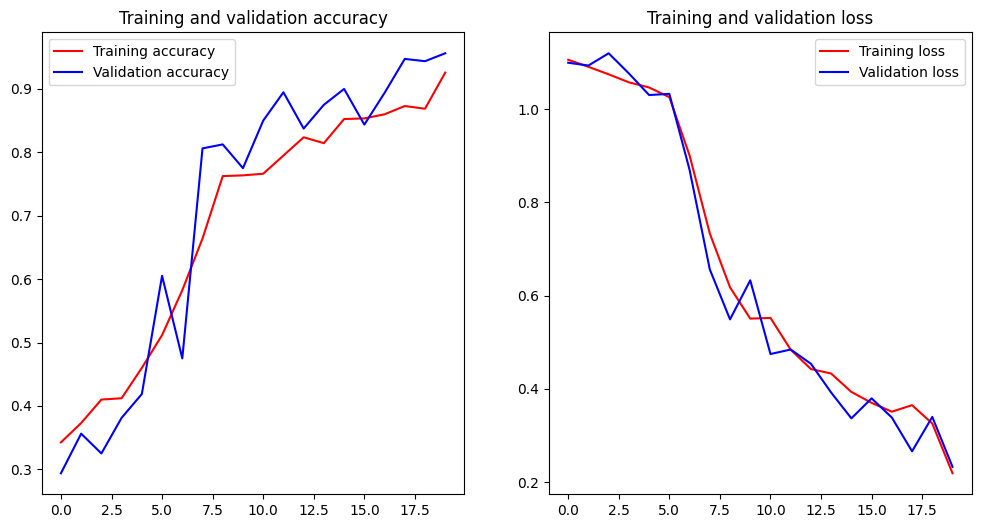

In [18]:
# Visualize accuracy and loss
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()


# **Predict Image**

Upload images for model prediction

Saving hand-2704013_1280.jpg to hand-2704013_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
hand-2704013_1280.jpg
Image is predicted as: Rock


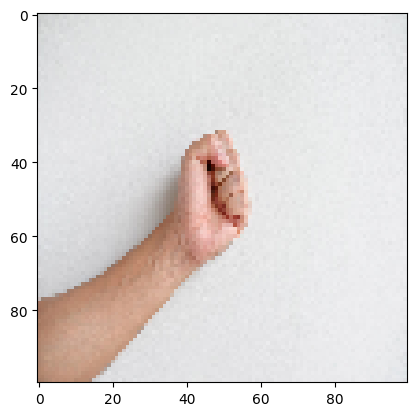

In [31]:
# Upload Image
uploaded = files.upload()

# Iterate over each uploaded image
for fn in uploaded.keys():
    # Predict Image
    path = fn
    img = image.load_img(path, target_size=(100, 100))

    # Display the predicted images
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Predict the class of images using the model
    classes = model.predict(images, batch_size=10)
    print(fn)

    # Display the prediction results by class.
    if classes[0, 0] == 0:
        print('Image is predicted as: Paper')
    elif classes[0, 1] == 0:
        print('Image is predicted as: Rock')
    else:
        print('Image is predicted as: Scissors')

In [ ]:
!git clone